In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info import Statevector

from qiskit.primitives import Sampler
# from qiskit_aer.primitives import SamplerV2

from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import AmplitudeEstimation
from qiskit_algorithms import IterativeAmplitudeEstimation

import os
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

In [2]:
# Define the file paths and names
sample_path = "C:\\projects\\quantum_uq\\data\\"
sample_filenames_ff = [
    "values_asym.csv"                 # 2^9 sample values
    # "values_sym.csv"                  # 2^9 sample values
]

# Initialize empty lists to store dataframes
df_fracture_flow = []

# Read CSV files and append dataframes to lists
for filename in sample_filenames_ff:
    df_fracture_flow.append(pd.read_csv(sample_path + filename, delimiter=' '))

In [3]:
ff_samples = df_fracture_flow[0]['ff_values'].values.reshape(-1,1).flatten()

# ff_samples = 10**3 * (ff_samples - np.mean(ff_samples)) + 0.4952211418615139    # 1/2
ff_samples = 10**2.5 * (ff_samples - np.mean(ff_samples)) + np.mean(ff_samples)   # 10**1 10**2 10**3

min_val_gt = np.min(ff_samples)
max_val_gt = np.max(ff_samples)
dif_max_min_val_gt = max_val_gt - min_val_gt

normalized_samples = (ff_samples - min_val_gt) / dif_max_min_val_gt

ff_mean = np.mean(ff_samples)
ff_var  = np.var(ff_samples)
ff_norm_mean = np.mean(normalized_samples)
ff_norm_var  = np.var(normalized_samples)

print(np.round(ff_mean,5), np.round(ff_var,5), np.round(ff_norm_mean,5), np.round(ff_norm_var,5))

0.07901 62.45688 0.40916 0.05865


In [4]:
# Function to calculate the sample average and the error
def sample_error(sample_mean, distribution_mean):
    error = np.abs(sample_mean - distribution_mean)
    return error

# Function to calculate the sample average and the error
def sample_relative_error(sample_mean, distribution_mean):
    if distribution_mean != 0:
        error = np.abs( sample_mean / distribution_mean - 1 )
    else:
        error = -1
    return error

# Function to generate tuple of (value,count) pairs
def unique_values_with_counts(arr):
    # Dictionary to count occurrences of each value
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Generate the result array with values and their counts
    result = [(value, count) for value, count in counts.items()]
    
    return result

In [5]:
# Function to generate psi basis state index tuples of (value,count) pairs
#   digits_precision_circuit - circuit precision base 2
def psi_basis_state_sample_index_counts(digits_precision_circuit=4, scaling_samples=20):

    dist_samples = np.array(random.sample(list(ff_samples), 2**(scaling_samples)))
    # dist_samples = ff_samples[0:2**scaling_samples]
    dist_sample_mean = np.mean(dist_samples)

    print(len(dist_samples))

    # Normalize samples between 0 and 1
    
    # normalized dist mean ground truth (all samples)

    dist_mean = np.mean(ff_samples)

    min_val_gt = np.min(ff_samples)
    max_val_gt = np.max(ff_samples)
    dif_max_min_val_gt = max_val_gt - min_val_gt

    dist_mean_normalized = (dist_mean - min_val_gt) / dif_max_min_val_gt

    # min_val = np.min(dist_samples)
    # max_val = np.max(dist_samples)
    # dif_max_min_val = max_val - min_val

    normalized_samples = (dist_samples - min_val_gt) / dif_max_min_val_gt
    # normalized_samples = (dist_samples - min_val) / dif_max_min_val
    
    # print(min_val)
    # print(max_val)
    # print(dif_max_min_val)
    # print(type(normalized_samples))
    # print(normalized_samples)

    dist_sample_mean_normalized = (dist_sample_mean - min_val_gt) / dif_max_min_val_gt
    # dist_sample_mean_normalized = (dist_sample_mean - min_val) / dif_max_min_val
    
    # compute index discrete distribution
    normalized_samples_int_dec_rnd = np.array([int(np.round(sample_value)) if np.round(sample_value) < 2**digits_precision_circuit else 2**digits_precision_circuit-1 for sample_value in normalized_samples * 2**digits_precision_circuit])
    
    # tally up sample values and counts
    index_circuit_unique_counts = unique_values_with_counts(normalized_samples_int_dec_rnd)

    print(dist_mean, dist_sample_mean, dist_mean_normalized, dist_sample_mean_normalized)
    # print(len(index_circuit_unique_counts))
    # print(index_circuit_unique_counts)

    print()

    return index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized

In [6]:
# Function to generate psi basis state index tuples of (value,count) pairs
#   index_circuit_unique_counts - psi basis state counts
#   digits_precision_circuit - circuit precision base 2
def psi_generate_qc(index_circuit_unique_counts, digits_precision_circuit=4, scaling_samples = 20):

    # number of bins for distribution
    estimate_samples_inv = 2**(-scaling_samples)
    
    # Create the full state vector of size dist_bins and initialize to zero
    state_vector = np.zeros(2**(digits_precision_circuit+1), dtype=complex)
    
    print(len(state_vector))
    
    # sample_value_index - psi basis state index
    # sample_value_phi - assigned to corresponding index (state psi) multiplied by probability
    
    # Assign the given amplitudes to the corresponding basis state indices
    psi_mean_normalized = 0
    for sample_value_index, count in index_circuit_unique_counts:
        sample_value_phi = sample_value_index * 2**(-digits_precision_circuit)
        state_vector[sample_value_index*2 + 1] = np.sqrt(sample_value_phi * count * estimate_samples_inv)
        state_vector[sample_value_index*2 + 0] = np.sqrt((1 - sample_value_phi) * count * estimate_samples_inv)
        psi_mean_normalized += sample_value_phi * count * estimate_samples_inv

    print(psi_mean_normalized)

    print()
    
    # Normalize the state vector
    state_vector /= np.linalg.norm(state_vector)
    
    # Create a quantum circuit with n+1 qubits
    qc = QuantumCircuit(digits_precision_circuit+1)
    
    # Use StatePreparation to initialize the state
    state_prep = StatePreparation(state_vector)
    qc.append(state_prep, list(range(digits_precision_circuit+1)))
    
    # # Draw the circuit
    # qc.draw(output='mpl', style='clifford')

    return qc

In [7]:
%%time
digits_precision_circuit_MAX   = 4    # base 2 precision = ceil(log2(10**digits_precision_base_10))
digits_precision_circuit_FIXED = 4    # fixed size state psi
digits_precision_OUT           = 5    # base 10 precision output

# Iterate over circuit digits of precision
qae_problem_list = []
qae_ae_list = []
qae_dist_mean_list = []
qae_sample_mean_list = []
qae_sample_error_list = []
qae_sample_relative_error_list = []
qae_sample_scaling_list = []
for digits_precision_circuit in range(1, digits_precision_circuit_MAX+1):

    dpc = digits_precision_circuit_FIXED
    # dpc = math.ceil( digits_precision_circuit_FIXED * digits_precision_circuit / digits_precision_circuit_MAX )

    ss = int(math.log2(len(ff_samples)))
    # ss = 2*digits_precision_circuit

    index_circuit_unique_counts, dist_mean_normalized, dist_sample_mean_normalized = psi_basis_state_sample_index_counts(digits_precision_circuit=dpc, scaling_samples=ss)

    qc = psi_generate_qc(index_circuit_unique_counts, digits_precision_circuit=dpc, scaling_samples=ss)

    problem = EstimationProblem(
        state_preparation=qc,  # A operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    neq = digits_precision_circuit
        
    sampler = Sampler()
    ae = AmplitudeEstimation(
        num_eval_qubits=neq,  # the number of evaluation qubits specifies circuit width and accuracy
        sampler=sampler,
    )

    ae_result = ae.estimate(problem)
    
    est_qoi_normalized = ae_result.estimation
    num_queries = ae_result.num_oracle_queries
    
    dist_mean_normalized_out = np.round(dist_mean_normalized, digits_precision_OUT)
    sample_mean_out = np.round(est_qoi_normalized, digits_precision_OUT)
    sample_error_out = np.round(sample_error(est_qoi_normalized, dist_mean_normalized), 2*digits_precision_OUT)
    sample_relative_error_out = np.round(sample_relative_error(est_qoi_normalized, dist_mean_normalized), 2*digits_precision_OUT)

    qae_problem_list.append(problem)
    qae_ae_list.append(ae)
    qae_dist_mean_list.append(dist_mean_normalized_out)
    qae_sample_mean_list.append(sample_mean_out)
    qae_sample_error_list.append(sample_error_out)
    qae_sample_relative_error_list.append(sample_relative_error_out)
    qae_sample_scaling_list.append(num_queries+1) # total applications of A


print(qae_dist_mean_list)
print(qae_sample_mean_list)
print(qae_sample_error_list)
print(qae_sample_relative_error_list)
print(qae_sample_scaling_list)

print()


# problem = problem_list[0]
# ae = ae_list[0]

# ae_circuit = ae.construct_circuit(problem)
# ae_circuit.decompose().draw(
#     "mpl", style="clifford"
# )  # decompose 1 level: exposes the Phase estimation circuit!


# print(dist_sample_mean, dist_sample_mean_normalized)



262144
0.07900658498247101 0.07900658498247104 0.40916138612251984 0.40916138612251984

32
0.4089317321777344

262144
0.07900658498247101 0.07900658498247103 0.40916138612251984 0.40916138612251984

32
0.4089317321777344

262144
0.07900658498247101 0.07900658498247104 0.40916138612251984 0.40916138612251984

32
0.4089317321777344

262144
0.07900658498247101 0.07900658498247104 0.40916138612251984 0.40916138612251984

32
0.4089317321777344

[0.40916, 0.40916, 0.40916, 0.40916]
[0.0, 0.5, 0.5, 0.5]
[0.4091613861, 0.0908386139, 0.0908386139, 0.0908386139]
[1.0, 0.2220116975, 0.2220116975, 0.2220116975]
[2, 4, 8, 16]

CPU times: total: 11.1 s
Wall time: 11.9 s


In [26]:
%%time
sample_scaling_MAX             = 9   # distribution sample size base 2
digits_precision_OUT           = 3   # base 10 precision output

cmc_dist_mean_list = []
cmc_sample_mean_list = []
cmc_sample_error_list = []
cmc_sample_relative_error_list = []
cmc_sample_scaling_list = []
for sample_scaling in range(1, sample_scaling_MAX+1):

    # sample dist for comparision sample scaling cmc vs qae

    # Generating data for the distributions
    # mean for fracture flow dist
    gt_ff = ff_samples
    # np.random.seed(4)
    sample_ff = np.array(random.sample(list(gt_ff), 2**(sample_scaling)))
    # sample_ff = np.array(random.sample(list(gt_ff), 2**(2*sample_scaling)))
    gt_ff_mean = np.mean(gt_ff)
    sample_ff_mean = np.mean(sample_ff)

    # print(len(gt_ff))
    # print(len(sample_ff))

    gt_ff_mean_out = np.round(gt_ff_mean, digits_precision_OUT)
    sample_ff_mean_out = np.round(sample_ff_mean, digits_precision_OUT)
    sample_error_out = np.round(sample_error(sample_ff_mean, gt_ff_mean), 2*digits_precision_OUT)
    sample_relative_error_out = np.round(sample_relative_error(sample_ff_mean, gt_ff_mean), 2*digits_precision_OUT)

    cmc_dist_mean_list.append(gt_ff_mean_out)
    cmc_sample_mean_list.append(sample_ff_mean_out)
    cmc_sample_error_list.append(sample_error_out)
    cmc_sample_relative_error_list.append(sample_relative_error_out)
    cmc_sample_scaling_list.append(2**sample_scaling)


print(cmc_dist_mean_list)
print(cmc_sample_mean_list)
print(cmc_sample_error_list)
print(cmc_sample_relative_error_list)
print(cmc_sample_scaling_list)

print()



[0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079, 0.079]
[5.703, 2.68, 6.11, 1.049, 0.392, -0.908, 0.546, 0.41, -0.113]
[5.624415, 2.600561, 6.030633, 0.970398, 0.313219, 0.986865, 0.466649, 0.330495, 0.192383]
[71.189198, 32.91575, 76.330767, 12.282489, 3.964465, 12.490917, 5.906463, 4.183138, 2.435023]
[2, 4, 8, 16, 32, 64, 128, 256, 512]

CPU times: total: 78.1 ms
Wall time: 104 ms


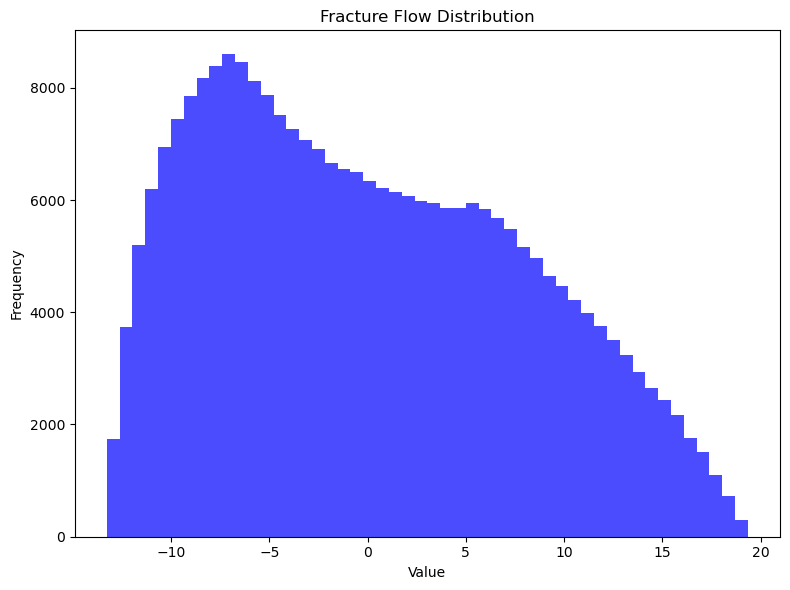

In [9]:
# data for the fracture flow distributions
data_FF = ff_samples

# Plotting the histograms of the distributions
plt.figure(figsize=(8, 6))

plt.hist(data_FF, bins=50, color='blue', alpha=0.7)
plt.title('Fracture Flow Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
# plt.savefig('dist_fracture_flow_asym.png', dpi=300)  # Save as a high-resolution image
plt.show()

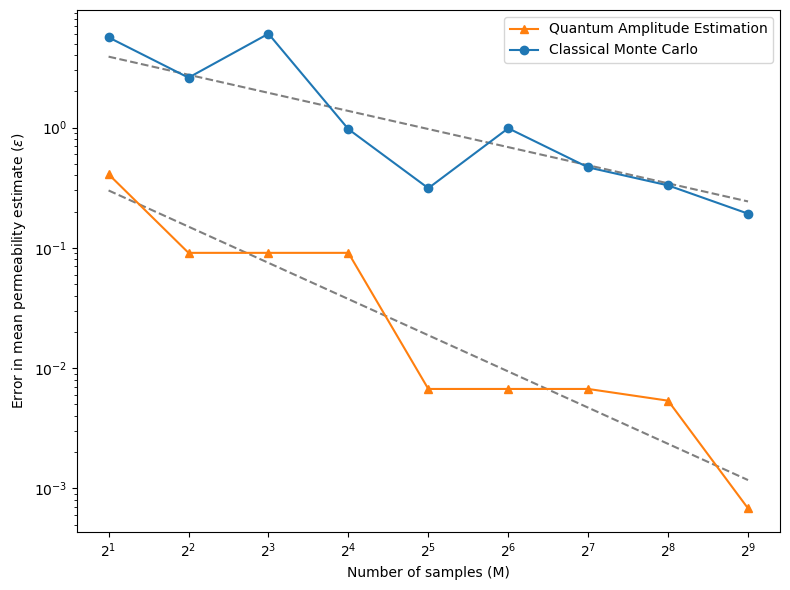

In [48]:
# plot error vs number of samples qae vs cmc / fracture flow distribution

# x_ss = np.linspace(2**1, 2**9, 100)                                            # number of samples
y_ae_error_vs_ss =   3/5 * 1/np.asarray(qae_sample_scaling_list)            # samples = 1/epsilon   => error = 1/samples
y_mc_error_vs_ss =  11/2 * 1/np.sqrt(np.asarray(cmc_sample_scaling_list))   # samples = 1/epsilon^2 => error = 1/sqrt(samples)

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(qae_sample_scaling_list, y_ae_error_vs_ss, color='black', linestyle='--', alpha=0.5) # -- -. : tab:orange
plt.plot(cmc_sample_scaling_list, y_mc_error_vs_ss, color='black', linestyle='--', alpha=0.5) #         tab:blue
plt.plot(qae_sample_scaling_list, qae_sample_error_list, color='tab:orange', marker='^', linestyle='-', label='Quantum Amplitude Estimation')
plt.plot(cmc_sample_scaling_list, cmc_sample_error_list, color='tab:blue', marker='o', linestyle='-', label='Classical Monte Carlo')
plt.xlabel('Number of samples (M)')
plt.ylabel('Error in mean permeability estimate ($\epsilon$)')
# plt.ylabel('error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.07901 62.45688 / 0.40916 0.05865]')
# plt.ylabel('error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.09814 32.44211 / 0.49522 0.04722]')
# plt.title('error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
# plt.grid(linestyle='--')
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_error_vs_samples_fracture_flow_asym.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

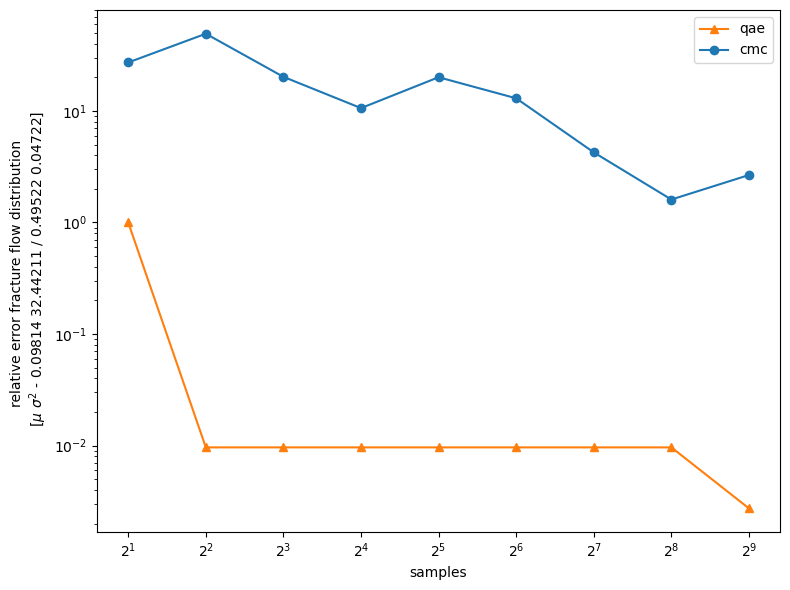

In [36]:
# plot relative error vs number of samples qae vs cmc / fracture flow distribution

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(qae_sample_scaling_list, qae_sample_relative_error_list, color='tab:orange', marker='^', linestyle='-', label='qae')
plt.plot(cmc_sample_scaling_list, cmc_sample_relative_error_list, color='tab:blue', marker='o', linestyle='-', label='cmc')
plt.xlabel('samples')
plt.ylabel('relative error fracture flow distribution \n [$\mu \\ \sigma^2$ - 0.09814 32.44211 / 0.49522 0.04722]')
# plt.title('relative error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_relative_error_vs_samples_fracture_flow.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

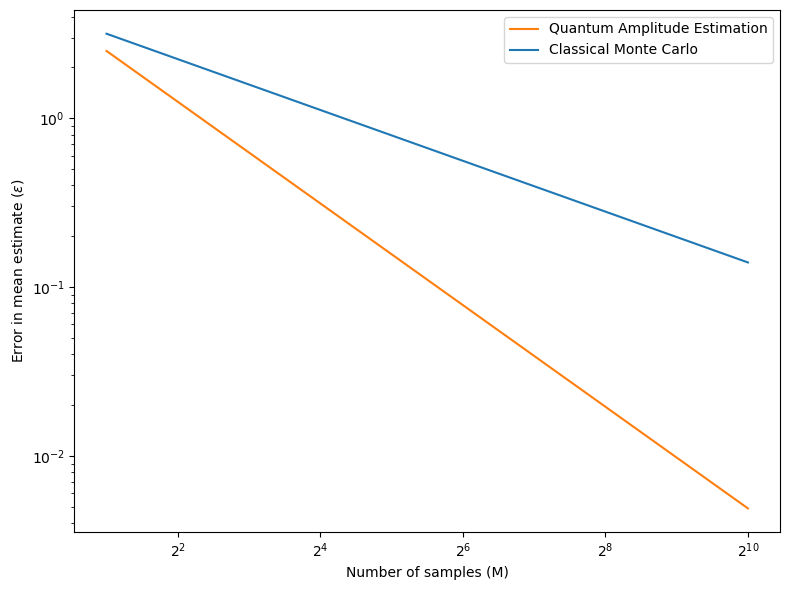

In [7]:
# plot theoretical error vs number of samples qae vs cmc (alpha = 0.05 / 95% CI)

x_ss = np.linspace(2**1, 2**10, 100)                # number of samples
y_ae_error_vs_ss =          5   * 1/x_ss            # samples =  5 * 1/epsilon   => error =        5  * 1/samples
y_mc_error_vs_ss =  np.sqrt(20) * 1/np.sqrt(x_ss)   # samples = 20 * 1/epsilon^2 => error =  sprt(20) * 1/sqrt(samples)

# Plotting the error
plt.figure(figsize=(8, 6))
plt.plot(x_ss, y_ae_error_vs_ss, color='tab:orange', linestyle='-', label='Quantum Amplitude Estimation') # -- -. : / alpha=0.5
plt.plot(x_ss, y_mc_error_vs_ss, color='tab:blue', linestyle='-', label='Classical Monte Carlo')
plt.xlabel('Number of samples (M)')
plt.ylabel('Error in mean estimate ($\epsilon$)')
# plt.title('error vs number of samples qae vs cmc')
plt.xscale('log', base=2)
plt.yscale('log')
# plt.grid(linestyle='--')
plt.legend()

# Save or display the plot
plt.tight_layout()
# plt.savefig('qae_cmc_error_vs_samples_theoretical.png', dpi=300)  # Save as a high-resolution image
plt.show() # display the plot

In [9]:
# 
n = 3
y_measured = list(range(0,2**n))
theta_est_nwrt_pi = [(value)*2**(-n) for value in y_measured]
# theta_est_nwrt_pi = [(value+0.5)*2**(-n) for value in y_measured]
out_est_a = [np.round(math.sin(value*math.pi)**2,5) for value in theta_est_nwrt_pi]

print(y_measured)
print(theta_est_nwrt_pi)
print(out_est_a)

[0, 1, 2, 3, 4, 5, 6, 7]
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
[0.0, 0.14645, 0.5, 0.85355, 1.0, 0.85355, 0.5, 0.14645]


In [13]:
theta_nwrt_pi = np.arcsin(math.sqrt(0.49781)) / math.pi
out_a = np.sin(theta_nwrt_pi*math.pi)**2

print(theta_nwrt_pi, out_a)

0.24930289912033501 0.49781


In [10]:
theta_nwrt_pi = np.arcsin(math.sqrt(0.40916)) / math.pi
out_a = np.sin(theta_nwrt_pi*math.pi)**2

print(theta_nwrt_pi, out_a)

0.22092324898335547 0.4091600000000001
